In [122]:
# %pip install python-dotenv
# %pip install seaborn
# %pip install tensorflow_data_validation

In [123]:
import os
import pandas as pd
import geopandas as gpd
import pygeos as pg
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
import sqlalchemy as sq
import sklearn as sk
import scipy as sp
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
from IPython.display import clear_output
from matplotlib import pyplot as plt
from DataService import DataService

In [124]:
# The following lines adjust the granularity of reporting.
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.chdir('/tf')
PGUSER = os.getenv('POSTGRES_USER')
PGPW = os.getenv('POSTGRES_PW')
PGDB = os.getenv('POSTGRES_DB')
NULLFLAG = -9999
ONEDAY = 24 * 60 * 60
WEEK = 7 * ONEDAY

In [125]:
# Connect to the database
pullService = DataService(PGDB, PGUSER, PGPW)
db_pull_con = pullService.connect()

pushService = DataService(PGDB, PGUSER, PGPW)
db_push_con = pushService.connect()

In [126]:
# load firewaterelev
fireWaterElev = "FireWaterElev"
query1 = "SELECT * FROM public.\"{}\";".format(fireWaterElev)
dfFireWaterElev = pd.read_sql(query1, db_pull_con)

In [127]:
print(dfFireWaterElev.count())
print(dfFireWaterElev.describe())
print(dfFireWaterElev.isnull().sum().sum())

EntryID          428
FIRE_ID          428
FIRENAME         428
YEAR             428
MONTH            428
DAY              428
REP_DATE         428
SIZE_HA          428
size_ha_bin      428
ClimateID        428
ElevationM       428
Dist_To_Water    428
utc              428
dtype: int64
       EntryID   YEAR  MONTH   DAY  SIZE_HA  size_ha_bin  ElevationM  \
count    428.0  428.0  428.0 428.0    428.0        428.0       428.0   
mean    3829.2 2013.9    6.8  15.9   8936.9          1.7       883.5   
std     3843.2    2.6    0.9   9.8  32731.6          1.1       460.7   
min       33.0 2010.0    5.0   1.0    200.7          0.0       334.0   
25%      757.5 2012.0    6.0   6.0    651.8          1.0       457.8   
50%     1736.0 2014.0    7.0  15.0   1880.7          2.0       787.5   
75%     8700.2 2016.0    7.0  25.2   5092.8          3.0      1280.0   
max    12248.0 2020.0   10.0  31.0 491429.4          3.0      1952.0   

       Dist_To_Water          utc  
count          428.0        4

In [128]:
# Load the data
fireWeather = "FireWeather"
query2 = "SELECT * FROM public.\"{}\";".format(fireWeather)
dfFireWeather = pd.read_sql(query2, db_pull_con)

In [129]:
print(dfFireWeather.count())
print(dfFireWeather.describe())
print(dfFireWeather.isnull().sum().sum())

EntryID                 428
FIRE_ID                 428
FIRENAME                428
YEAR                    428
MONTH                   428
DAY                     428
REP_DATE                428
SIZE_HA                 428
size_ha_bin             428
ClimateID               428
OneYear                 428
OneMonth                428
OneMeanTemp             428
OneMinTemp              428
OneMaxTemp              428
OneMeanDewPoint         428
OneMinDewPoint          428
OneMaxDewPoint          428
OneMeanHumidity         428
OneMinHumidity          428
OneMaxHumidity          428
OneMeanPressure         426
OneMinPressure          426
OneMaxPressure          426
OneMeanWindSpeed        426
OneMinWindSpeed         426
OneMaxWindSpeed         426
OneMeanWindChill        426
OneMinWindChill         426
OneMaxWindChill         426
OneTotalPrecip          428
OneMeanWindDirection    426
TwoYear                 428
TwoMonth                428
TwoMeanTemp             428
TwoMinTemp          

In [130]:
# Load WeatherDataHourlyAggDaily
weatherDataHourlyAggDaily = "WeatherDataHourlyAggDaily"
query3 = "SELECT * FROM public.\"{}\";".format(weatherDataHourlyAggDaily)
dfWeatherDaily = pd.read_sql(query3, db_pull_con)

In [131]:
print(dfWeatherDaily.count())
print(dfWeatherDaily.describe())
print(dfWeatherDaily.isnull().sum().sum())

ClimateID            72790
ProvinceCode         72790
Year                 72790
Month                72790
Day                  72790
MeanTemp             72790
MinTemp              72790
MaxTemp              72790
MeanDewPoint         71852
MinDewPoint          71852
MaxDewPoint          71852
MeanHumidity         71852
MinHumidity          71852
MaxHumidity          71852
MeanPressure         71487
MinPressure          71487
MaxPressure          71487
MeanWindSpeed        71487
MinWindSpeed         71487
MaxWindSpeed         71487
MeanWindChill        71487
MinWindChill         71487
MaxWindChill         71487
TotalPrecip          72790
MeanWindDirection    71487
utc                  72790
dtype: int64
         Year   Month     Day  MeanTemp  MinTemp  MaxTemp  MeanDewPoint  \
count 72790.0 72790.0 72790.0   72790.0  72790.0  72790.0       71852.0   
mean   2015.7     6.5    15.7      -0.4     -5.7      4.4          -5.6   
std       3.4     3.5     8.8      14.8     14.7     15.3   

Sums of max temp humidity days with precipitation in time period

In [132]:
dfFWEW = dfFireWaterElev.copy(deep=True)

In [133]:
# add 7 day sum max temp column, 7 day sum humidity column, 7 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '7daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '7daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '7daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [134]:
print(dfFWEW.count())
print(dfFWEW.describe())
print(dfFWEW.isnull().sum().sum())

EntryID            428
FIRE_ID            428
FIRENAME           428
YEAR               428
MONTH              428
DAY                428
REP_DATE           428
SIZE_HA            428
size_ha_bin        428
ClimateID          428
ElevationM         428
Dist_To_Water      428
utc                428
7daySumMaxTemp     428
7daySumHumidity    428
7daySumPrecip      428
dtype: int64
       EntryID   YEAR  MONTH   DAY  SIZE_HA  size_ha_bin  ElevationM  \
count    428.0  428.0  428.0 428.0    428.0        428.0       428.0   
mean    3829.2 2013.9    6.8  15.9   8936.9          1.7       883.5   
std     3843.2    2.6    0.9   9.8  32731.6          1.1       460.7   
min       33.0 2010.0    5.0   1.0    200.7          0.0       334.0   
25%      757.5 2012.0    6.0   6.0    651.8          1.0       457.8   
50%     1736.0 2014.0    7.0  15.0   1880.7          2.0       787.5   
75%     8700.2 2016.0    7.0  25.2   5092.8          3.0      1280.0   
max    12248.0 2020.0   10.0  31.0 491429.4

In [135]:
# add 14 day sum max temp column, 14 day sum humidity column, 14 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '14daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 2 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '14daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 2 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '14daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 2 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [136]:
# add 21 day sum max temp column, 21 day sum humidity column, 21 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '21daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 3 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '21daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 3 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '21daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 3 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [137]:
# add 28 day sum max temp column, 28 day sum humidity column, 28 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '28daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 4 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '28daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 4 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '28daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 4 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [138]:
# add 35 day sum max temp column, 35 day sum humidity column, 35 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '35daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 5 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '35daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 5 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '35daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 5 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [139]:
# add 42 day sum max temp column, 42 day sum humidity column, 42 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '42daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 6 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '42daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 6 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '42daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 6 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [140]:
# add 49 day sum max temp column, 49 day sum humidity column, 49 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '49daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 7 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '49daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 7 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '49daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 7 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [141]:
# add 56 day sum max temp column, 56 day sum humidity column, 56 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '56daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 8 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '56daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 8 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '56daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 8 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [142]:
print(dfFWEW.count())
print(dfFWEW.describe())
print(dfFWEW.isnull().sum().sum())

EntryID             428
FIRE_ID             428
FIRENAME            428
YEAR                428
MONTH               428
DAY                 428
REP_DATE            428
SIZE_HA             428
size_ha_bin         428
ClimateID           428
ElevationM          428
Dist_To_Water       428
utc                 428
7daySumMaxTemp      428
7daySumHumidity     428
7daySumPrecip       428
14daySumMaxTemp     428
14daySumHumidity    428
14daySumPrecip      428
21daySumMaxTemp     428
21daySumHumidity    428
21daySumPrecip      428
28daySumMaxTemp     428
28daySumHumidity    428
28daySumPrecip      428
35daySumMaxTemp     428
35daySumHumidity    428
35daySumPrecip      428
42daySumMaxTemp     428
42daySumHumidity    428
42daySumPrecip      428
49daySumMaxTemp     428
49daySumHumidity    428
49daySumPrecip      428
56daySumMaxTemp     428
56daySumHumidity    428
56daySumPrecip      428
dtype: int64
       EntryID   YEAR  MONTH   DAY  SIZE_HA  size_ha_bin  ElevationM  \
count    428.0  428.0  428.

In [143]:
# group the fires with same utc and average the N day columns
dfFWEW = dfFWEW.groupby(['utc', 'YEAR', 'MONTH', 'DAY'], as_index=False).agg({'SIZE_HA':['sum'],
                                                     '7daySumMaxTemp':['mean'], '7daySumHumidity':['mean'], '7daySumPrecip':['mean'],
                                                     '14daySumMaxTemp':['mean'], '14daySumHumidity':['mean'], '14daySumPrecip':['mean'],
                                                     '21daySumMaxTemp':['mean'], '21daySumHumidity':['mean'], '21daySumPrecip':['mean'],
                                                     '28daySumMaxTemp':['mean'], '28daySumHumidity':['mean'], '28daySumPrecip':['mean'],
                                                     '35daySumMaxTemp':['mean'], '35daySumHumidity':['mean'], '35daySumPrecip':['mean'],
                                                     '42daySumMaxTemp':['mean'], '42daySumHumidity':['mean'], '42daySumPrecip':['mean'],
                                                     '49daySumMaxTemp':['mean'], '49daySumHumidity':['mean'], '49daySumPrecip':['mean'],
                                                     '56daySumMaxTemp':['mean'], '56daySumHumidity':['mean'], '56daySumPrecip':['mean']})

In [144]:
print(dfFWEW.count())
print(dfFWEW.describe())
print(dfFWEW.isnull().sum().sum())

utc                       225
YEAR                      225
MONTH                     225
DAY                       225
SIZE_HA           sum     225
7daySumMaxTemp    mean    225
7daySumHumidity   mean    225
7daySumPrecip     mean    225
14daySumMaxTemp   mean    225
14daySumHumidity  mean    225
14daySumPrecip    mean    225
21daySumMaxTemp   mean    225
21daySumHumidity  mean    225
21daySumPrecip    mean    225
28daySumMaxTemp   mean    225
28daySumHumidity  mean    225
28daySumPrecip    mean    225
35daySumMaxTemp   mean    225
35daySumHumidity  mean    225
35daySumPrecip    mean    225
42daySumMaxTemp   mean    225
42daySumHumidity  mean    225
42daySumPrecip    mean    225
49daySumMaxTemp   mean    225
49daySumHumidity  mean    225
49daySumPrecip    mean    225
56daySumMaxTemp   mean    225
56daySumHumidity  mean    225
56daySumPrecip    mean    225
dtype: int64
               utc   YEAR MONTH   DAY  SIZE_HA 7daySumMaxTemp 7daySumHumidity  \
                                    

In [145]:
dfEval = dfFWEW

In [146]:
# randomly select 6 years from 2010-2019 for training
dfTrain = dfEval[dfEval['YEAR'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016])]
dfValidate = dfEval[dfEval['YEAR'].isin([2017, 2018])]
dfTest = dfEval[dfEval['YEAR'].isin([2019, 2020])]

In [147]:
# Store our random selection, run once
randomTrain = "RandomTrain"
dfTrain.to_sql(randomTrain, db_push_con, if_exists='replace', index=False)

randomTest = "RandomTest"
dfTest.to_sql(randomTest, db_push_con, if_exists='replace', index=False)

randomValidate = "RandomValidate"
dfValidate.to_sql(randomValidate, db_push_con, if_exists='replace', index=False)

36

In [148]:
trainStats = tfdv.generate_statistics_from_dataframe(dfTrain)

In [149]:
tfdv.visualize_statistics(trainStats)


In [150]:
schema = tfdv.infer_schema(statistics=trainStats)
tfdv.display_schema(schema=schema)


,Type,Presence,Valency,Domain
Feature name,,,,
"'(\'utc\', \'\')'",INT,required,,-
"'(\'YEAR\', \'\')'",INT,required,,-
"'(\'MONTH\', \'\')'",INT,required,,-
"'(\'DAY\', \'\')'",INT,required,,-
"'(\'SIZE_HA\', \'sum\')'",FLOAT,required,,-
"'(\'7daySumMaxTemp\', \'mean\')'",FLOAT,required,,-
"'(\'7daySumHumidity\', \'mean\')'",FLOAT,required,,-
"'(\'7daySumPrecip\', \'mean\')'",FLOAT,required,,-
"'(\'14daySumMaxTemp\', \'mean\')'",FLOAT,required,,-


In [151]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay


Y_train = dfTrain['SIZE_HA'].copy(deep=True)
Y_train.fillna(Y_train.mean(), inplace=True)

Y_train_discrete = dfTrain['size_ha_bin'].copy(deep=True)
Y_train_discrete.fillna(Y_train_discrete.min(), inplace=True)



X_train = dfTrain.drop(columns=['MONTH', 'SIZE_HA', 'OneMonth', 'OneYear', 'TwoMonth', 'TwoYear', 'EntryID', 'size_ha_bin', 'YEAR', 'DAY', 'FIRE_ID', 'FIRENAME', 'ClimateID', 'REP_DATE'])
X_train.fillna(X_train.mean(), inplace=True)
X_train_one = X_train.drop(columns=['TwoMeanTemp', 'TwoMinTemp', 'TwoMaxTemp', 'TwoMeanDewPoint', 'TwoMinDewPoint', 'TwoMaxDewPoint',
                                     'TwoMeanHumidity', 'TwoMinHumidity', 'TwoMaxHumidity', 'TwoMeanPressure', 'TwoMinPressure',
                                     'TwoMaxPressure', 'TwoMeanWindSpeed', 'TwoMinWindSpeed', 'TwoMaxWindSpeed', 'TwoMeanWindChill',
                                     'TwoMinWindChill', 'TwoMaxWindChill', 'TwoTotalPrecip', 'TwoMeanWindDirection'])
X_train_two = X_train.drop(columns=['OneMeanTemp', 'OneMinTemp', 'OneMaxTemp', 'OneMeanDewPoint', 'OneMinDewPoint', 'OneMaxDewPoint',
                                     'OneMeanHumidity', 'OneMinHumidity', 'OneMaxHumidity', 'OneMeanPressure', 'OneMinPressure',
                                     'OneMaxPressure', 'OneMeanWindSpeed', 'OneMinWindSpeed', 'OneMaxWindSpeed', 'OneMeanWindChill',
                                      'OneMinWindChill', 'OneMaxWindChill', 'OneTotalPrecip', 'OneMeanWindDirection'])

X_train_means_one = X_train_one.drop(columns=['OneMinTemp', 'OneMaxTemp', 'OneMinDewPoint', 'OneMaxDewPoint', 'OneMinHumidity', 'OneMaxHumidity',
                                              'OneMinPressure', 'OneMaxPressure', 'OneMinWindSpeed', 'OneMaxWindSpeed', 'OneMinWindChill',
                                              'OneMaxWindChill'])

X_train_means_two = X_train_two.drop(columns=['TwoMinTemp', 'TwoMaxTemp', 'TwoMinDewPoint', 'TwoMaxDewPoint', 'TwoMinHumidity', 'TwoMaxHumidity',
                                                'TwoMinPressure', 'TwoMaxPressure', 'TwoMinWindSpeed', 'TwoMaxWindSpeed', 'TwoMinWindChill',
                                                'TwoMaxWindChill'])

dfTrainScaled = dfTrain.copy(deep=True)
dfTrainScaled.fillna(dfTrainScaled.mean(), inplace=True)
dfTrainScaled = dfTrainScaled.drop(columns=['MONTH', 'OneMonth', 'OneYear', 'TwoMonth', 'TwoYear', 'EntryID', 'size_ha_bin', 'YEAR', 'DAY', 'FIRE_ID', 'FIRENAME', 'ClimateID', 'REP_DATE'])

# regularize y using log scale
Y_train = np.log(Y_train)
# regularize y values using z score
Y_train = (Y_train - Y_train.mean()) / Y_train.std()
# set max value to 3 zscore
Y_train[Y_train > 3] = 3

In [152]:
dfTrainScaled = dfTrain.copy(deep=True)

In [153]:
dfTrainScaled['SIZE_HA'] = np.log(dfTrainScaled['SIZE_HA'])
# regularize y values using z score
dfTrainScaled = (dfTrainScaled - dfTrainScaled.mean()) / dfTrainScaled.std()
# set max value to 3 zscore
dfTrainScaled[dfTrainScaled > 3] = 3
# set min value to -3 zscore
dfTrainScaled[dfTrainScaled < -3] = -3

# shift the wole train set to be positive
dfTrainScaled = dfTrainScaled + 3

In [154]:
trainStats2 = tfdv.generate_statistics_from_dataframe(dfTrainScaled)
tfdv.visualize_statistics(trainStats2)

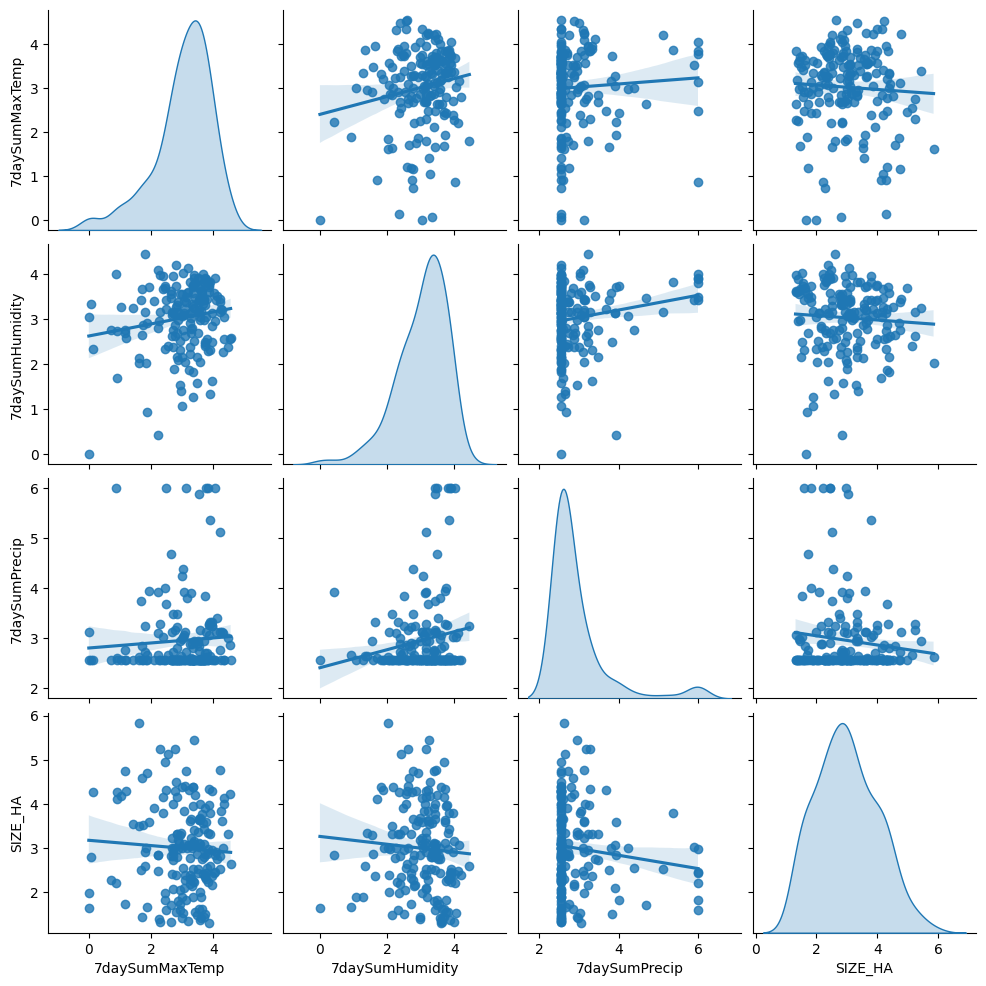

In [155]:
# one week data
weekData = pd.DataFrame()
train_dataset = dfTrainScaled.copy(deep=True)

# create a dataframe with the 7 day data
weekData['7daySumMaxTemp'] = train_dataset['7daySumMaxTemp']
weekData['7daySumHumidity'] = train_dataset['7daySumHumidity']
weekData['7daySumPrecip'] = train_dataset['7daySumPrecip']
weekData['SIZE_HA'] = train_dataset['SIZE_HA']


pairplotOne = sns.pairplot(weekData, kind="reg", diag_kind="kde")

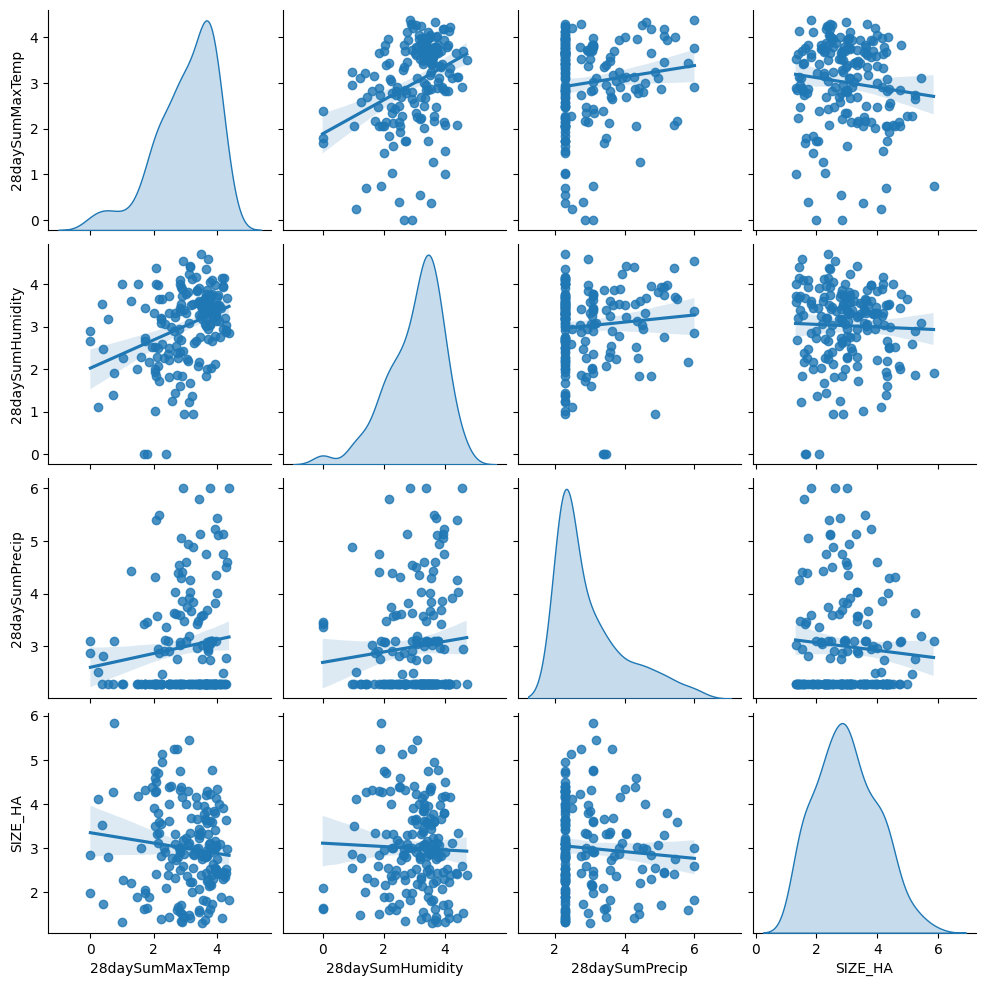

In [156]:
# one month data
monthData = pd.DataFrame()
train_dataset = dfTrainScaled.copy(deep=True)

# create a dataframe with the 28 day data
monthData['28daySumMaxTemp'] = train_dataset['28daySumMaxTemp']
monthData['28daySumHumidity'] = train_dataset['28daySumHumidity']
monthData['28daySumPrecip'] = train_dataset['28daySumPrecip']
monthData['SIZE_HA'] = train_dataset['SIZE_HA']

pairplotTwo = sns.pairplot(monthData, kind="reg", diag_kind="kde")

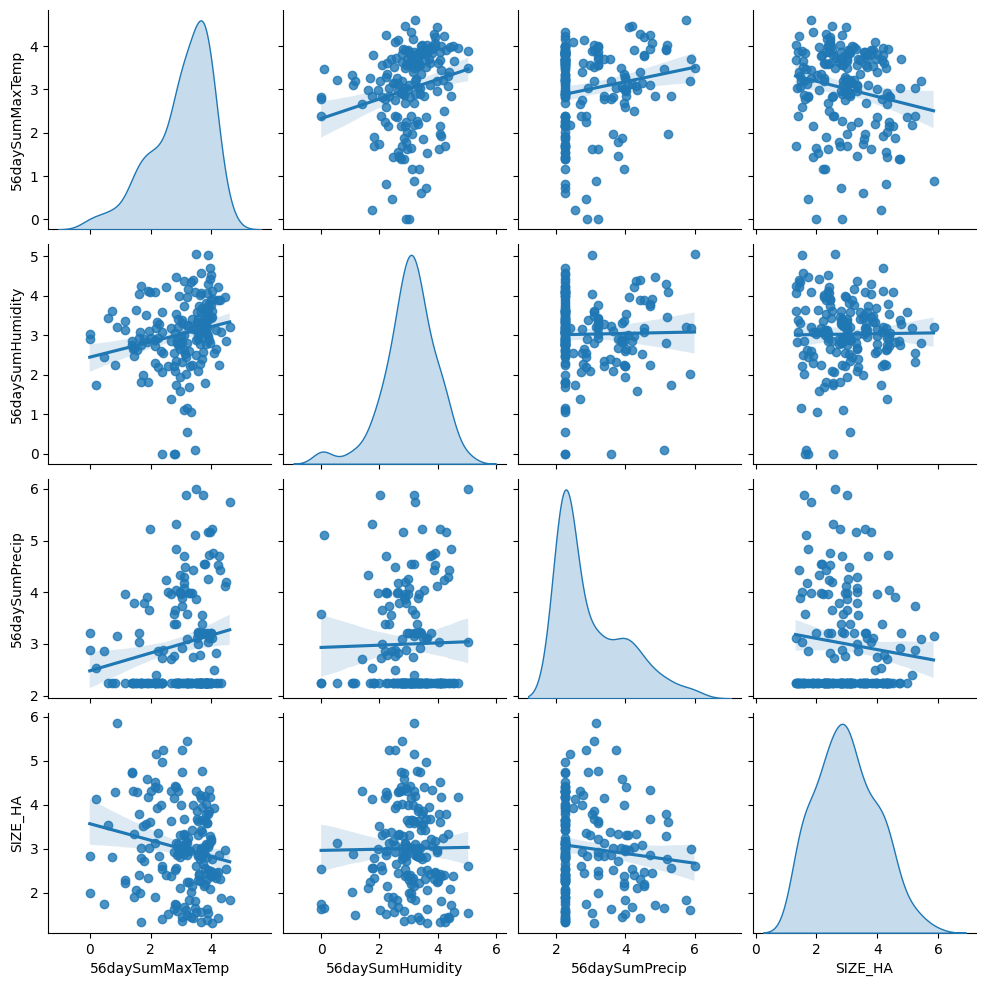

In [157]:
# two month data
twoMonthData = pd.DataFrame()
train_dataset = dfTrainScaled.copy(deep=True)

# create a dataframe with the 56 day data
twoMonthData['56daySumMaxTemp'] = train_dataset['56daySumMaxTemp']
twoMonthData['56daySumHumidity'] = train_dataset['56daySumHumidity']
twoMonthData['56daySumPrecip'] = train_dataset['56daySumPrecip']
twoMonthData['SIZE_HA'] = train_dataset['SIZE_HA']

pairplotThree = sns.pairplot(twoMonthData, kind="reg", diag_kind="kde")

In [164]:
print(dfTrainScaled['SIZE_HA'])


     sum
0    2.8
1    2.3
2    1.3
3    4.2
4    1.9
5    4.3
6    4.4
7    4.5
8    1.4
9    3.9
10   5.0
11   2.8
12   3.6
13   4.4
14   3.1
15   1.6
16   3.0
17   3.2
18   1.8
19   4.3
20   2.8
21   2.3
22   3.9
23   4.2
24   3.6
25   3.7
26   1.4
27   3.8
28   2.8
29   3.6
30   3.1
31   1.6
32   2.5
33   3.1
34   2.5
35   1.4
36   1.7
37   1.9
38   4.3
39   4.7
40   4.7
41   4.3
42   4.3
43   3.6
44   3.5
45   4.0
46   3.1
47   2.9
48   1.5
49   2.2
50   2.0
51   3.2
52   2.9
53   2.2
54   2.5
55   1.9
56   4.2
57   1.6
58   1.3
59   1.5
60   3.0
61   2.0
62   2.1
63   2.8
64   1.4
65   3.0
66   1.6
67   2.9
68   4.3
69   3.4
70   3.9
71   4.1
72   4.0
73   3.4
74   3.1
75   2.3
76   2.4
77   2.4
78   2.4
79   2.3
80   2.4
81   2.0
82   3.3
83   2.7
84   2.8
85   3.8
86   2.3
87   2.4
88   3.3
89   4.2
90   2.6
91   3.6
92   4.8
93   2.9
94   3.6
95   3.9
96   2.4
97   3.8
98   2.5
99   2.1
100  3.2
101  1.3
102  1.5
103  1.7
104  3.5
105  2.2
106  4.6
107  3.6
108  4.4
109  1.5
1

In [165]:
dfTemp = pd.DataFrame()
dfTemp['SIZE_HA'] = dfTrainScaled['SIZE_HA'].copy(deep=True)
# categorize size_ha into 4 classes by quantile
dfTrainScaled['SIZE_BIN'] = pd.qcut(dfTemp['SIZE_HA'], 4, labels=False)

In [166]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(dfTrainScaled.drop(columns=['SIZE_HA']), dfTrainScaled['SIZE_BIN'])

/tmp/ipykernel_21826/4103045903.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  clf.fit(dfTrainScaled.drop(columns=['SIZE_HA']), dfTrainScaled['SIZE_BIN'])


SVC(decision_function_shape='ovo')

In [172]:

print(dfTrainScaled.count())
print(dfTrainScaled.isna().sum().sum())
print(dfTrainScaled.dtypes)

utc                       178
YEAR                      178
MONTH                     178
DAY                       178
SIZE_HA           sum     178
7daySumMaxTemp    mean    178
7daySumHumidity   mean    178
7daySumPrecip     mean    178
14daySumMaxTemp   mean    178
14daySumHumidity  mean    178
14daySumPrecip    mean    178
21daySumMaxTemp   mean    178
21daySumHumidity  mean    178
21daySumPrecip    mean    178
28daySumMaxTemp   mean    178
28daySumHumidity  mean    178
28daySumPrecip    mean    178
35daySumMaxTemp   mean    178
35daySumHumidity  mean    178
35daySumPrecip    mean    178
42daySumMaxTemp   mean    178
42daySumHumidity  mean    178
42daySumPrecip    mean    178
49daySumMaxTemp   mean    178
49daySumHumidity  mean    178
49daySumPrecip    mean    178
56daySumMaxTemp   mean    178
56daySumHumidity  mean    178
56daySumPrecip    mean    178
SIZE_BIN                  178
dtype: int64
0
utc                       float64
YEAR                      float64
MONTH            

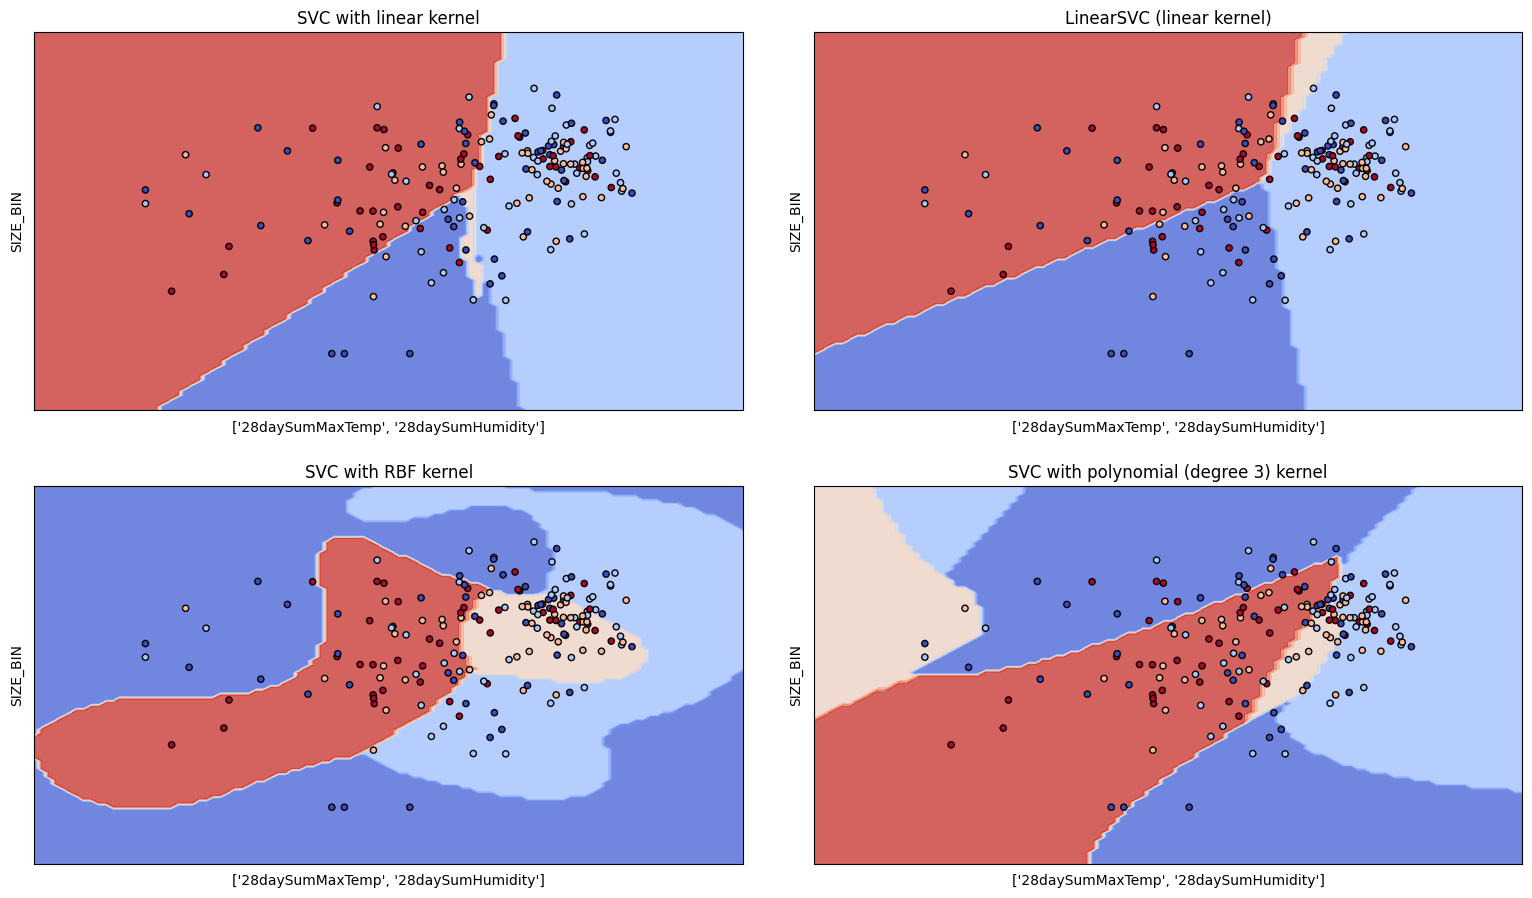

In [185]:
C = 0.9  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C, decision_function_shape='ovo'),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C, decision_function_shape='ovo'),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C, decision_function_shape='ovo'),
)
dfTemp = pd.DataFrame()
dfTemp['28daySumMaxTemp'] = dfTrainScaled['28daySumMaxTemp'].copy(deep=True)
dfTemp['28daySumHumidity'] = dfTrainScaled['28daySumHumidity'].copy(deep=True)
models = (clf.fit(dfTemp, dfTrainScaled['SIZE_BIN']) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2, figsize=(19.20, 10.80))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

X0, X1 = dfTemp['28daySumMaxTemp'], dfTemp['28daySumHumidity']

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        dfTemp,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=['28daySumMaxTemp', '28daySumHumidity'],
        ylabel="SIZE_BIN",
    )
    ax.scatter(X0, X1, c=dfTrainScaled['SIZE_BIN'], cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 

Since you don't need to understand model building code right now, we've hidden this code cell.  You may optionally double-click the following headline to see the code that builds and trains a model.

In [ ]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        


def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs. 
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Defined the build_model and train_model functions.")

## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

You may optionally double-click the headline to see the matplotlib code, but note that writing matplotlib code is not an important part of learning ML programming.

In [ ]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = dfTrainScaled.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 6
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

## Call the model functions

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature. 


In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 5

# Specify the feature and the label.
my_feature = "OneMeanHumidity"  # the total number of rooms on a specific city block.
my_label="SIZE_HA" # the median value of a house on a specific city block.
#my_label="size_ha_bin"
# That is, you're going to create a model that predicts house value based 
# solely on total_rooms.  

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, dfTrainScaled, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

## Use the model to make predictions

You can use the trained model to make predictions. In practice, [you should make predictions on examples that are not used in training](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). However, for this exercise, you'll just work with a subset of the same training dataset. A later Colab exercise will explore ways to make predictions on examples not used in training.

First, run the following code to define the house prediction function:

In [ ]:
def predict_house_values(n, feature, label):
  """Predict house values based on a feature."""

  batch = dfTrainScaled[feature][200:200 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (dfTrain[feature][400+i], dfTrain[label][400+i], predicted_values[i][0] ))

In [ ]:
predict_house_values(10, my_feature, my_label)